# 倉庫問題¶
倉庫問題は、多くの教科書で取り上げられるよく知られた最適化事例です。 問題は、候補となる倉庫の場所のセットと店舗のセットが与えられた場合に、どの倉庫をオープンし、どの倉庫がどの店舗にサービスを提供するかを決定することで構成されます。

## 入力データ¶
データは次のように提供されます。

- 各倉庫にはタプル (名前、容量、固定コスト) が必要です。名前は倉庫の一意の名前、容量は供給できる店舗の最大数、固定コストは倉庫を開くために発生するコストです。
- 各カップル (倉庫、店舗) について、この倉庫によってこの店舗に供給するコストを見積もる Supply_cost。
データを表現するコンパクトな方法は Python 辞書です。倉庫タプルごとに、すべての店舗のすべての供給コストをリストします。

## ビジネス上の決定¶
問題は、どの倉庫をオープンするか、また店舗ごとにどの倉庫から商品を供給するかを決定することにあります。

## ビジネス上の制約¶
決定は、次の (単純化された) ビジネス制約を満たす必要があります。

1. 統一性: 各店舗は 1 つの固有の倉庫から供給されます
2. 店舗はオープン倉庫によってのみ供給可能です
3. 容量: 倉庫が供給する店舗の数はその容量よりも少なくなければなりません

## ビジネス目標¶
目標は、意思決定によって発生する次の 2 つのコストからなる総コストを最小限に抑えることです。

- 合計開設コストは、すべての開いている倉庫にわたる開設コストの合計です。
- 総供給コストは、選択したすべての (倉庫、店舗) ペアの供給コストの合計です。


https://ibmdecisionoptimization.github.io/docplex-doc/mp/warehouse.html

# ライブラリーのインポート

In [ ]:
#ライブラリーのインポート
try:
    import docplex.mp
except:
    !pip install docplex
from docplex.mp.environment import Environment
env = Environment()
env.print_information()



まず、小さなウェアハウス データセットを定義しましょう。

In [2]:
#倉庫情報：許容店舗数、固定費、各店舗と倉庫間の輸送費
WAREHOUSES = {
    ('Bonn', 1, 20): [20, 28, 74, 2, 46, 42, 1, 10, 93, 47],
    ('Bordeaux', 4, 35): [24, 27, 97, 55, 96, 22, 5, 73, 35, 65],
    ('Brussels', 2, 28): [30, 74, 70, 61, 34, 59, 56, 96, 46, 95],
    ('London', 2, 32): [11, 82, 71, 73, 59, 29, 73, 13, 63, 55],
    ('Paris', 1, 37): [25, 83, 96, 69, 83, 67, 59, 43, 85, 71],
    ('Rome', 2, 25): [30, 74, 70, 61, 54, 59, 56, 96, 46, 95]
}

print(WAREHOUSES)
print("#candidate warehouses=%d" % len(WAREHOUSES))
print("#stores to supply=%d" % len(list(WAREHOUSES.values())[0]))

{('Bonn', 1, 20): [20, 28, 74, 2, 46, 42, 1, 10, 93, 47], ('Bordeaux', 4, 35): [24, 27, 97, 55, 96, 22, 5, 73, 35, 65], ('Brussels', 2, 28): [30, 74, 70, 61, 34, 59, 56, 96, 46, 95], ('London', 2, 32): [11, 82, 71, 73, 59, 29, 73, 13, 63, 55], ('Paris', 1, 37): [25, 83, 96, 69, 83, 67, 59, 43, 85, 71], ('Rome', 2, 25): [30, 74, 70, 61, 54, 59, 56, 96, 46, 95]}
#candidate warehouses=6
#stores to supply=10


In [3]:
#len(WAREHOUSES[('Bonn', 1, 20)])
#WAREHOUSES.values()
#itervalues(WAREHOUSES).next()
list(WAREHOUSES.values())

[[20, 28, 74, 2, 46, 42, 1, 10, 93, 47],
 [24, 27, 97, 55, 96, 22, 5, 73, 35, 65],
 [30, 74, 70, 61, 34, 59, 56, 96, 46, 95],
 [11, 82, 71, 73, 59, 29, 73, 13, 63, 55],
 [25, 83, 96, 69, 83, 67, 59, 43, 85, 71],
 [30, 74, 70, 61, 54, 59, 56, 96, 46, 95]]

ディクショナリ内の各キーは、名前 (文字列)、容量 (正の整数)、および固定コスト (これも正) の 3 つのフィールドを持つタプルです。 各値は長さ 10 (提供するストアの数) のリストです。 リストの k^ 番目の要素は、倉庫から k^ 番目の店舗までの供給コストです。 例えば、

- ロンドンの倉庫は最大 2 店舗で供給可能
- ロンドン倉庫の開設コストは32です
- ロンドンからの店舗1への供給にかかるコストは 11 です。

In [4]:
#pandasで表として表示
import pandas as pd
df=pd.DataFrame(WAREHOUSES)
df.index = df.index + 1
df

,Bonn,Bordeaux,Brussels,London,Paris,Rome
,1,4,2,2,1,2
,20,35,28,32,37,25
1,20,24,30,11,25,30
2,28,27,74,82,83,74
3,74,97,70,71,96,70
4,2,55,61,73,69,61
5,46,96,34,59,83,54
6,42,22,59,29,67,59
7,1,5,56,73,59,56
8,10,73,96,13,43,96


# 数理モデル
# DOcplex による解決¶
では、DOcplex を使用してこの問題を解決しましょう。 まず、倉庫や店舗に関する情報を明確かつ便利な方法で保存するための名前付きタプルを定義します。

In [5]:
from collections import namedtuple
# 倉庫のクラス
class TWareHouse(namedtuple("TWarehouse1", ["id", "capacity", "fixed_cost"])):
    def __str__(self):
        return self.id
# 店舗IDのクラス
class TStore(namedtuple("TStore1", ["id"])):
    def __str__(self):
        return 'store_%d' % self.id

次に、ウェアハウスとストアのタプルのセットを計算します。 six モジュールの itervalue の使用は、Python 2 と Python3 間での移植性を確保するための技術です。 便宜上、1 から nb_stores までの整数範囲でストアをモデル化することにしました。

In [6]:
from six import itervalues

# 店舗数
nb_stores = 0 if not WAREHOUSES else len(next(itervalues(WAREHOUSES)))
# 倉庫;許容店舗数と固定費を含む名前付きタプルとして定義
warehouses = [TWareHouse(*wrow) for wrow in WAREHOUSES.keys()]
# 輸送コスト;倉庫ディクショナリをそのまま使用
supply_costs = WAREHOUSES
# 店舗IDのリスト;便宜上、storesは0からではなく1からNSTORESまでカウントします
stores = [TStore(idx) for idx in range(1, nb_stores + 1)]

In [7]:
# 名前付きタプルの中身確認
print(warehouses[0])
print(stores[0])

Bonn
store_1


# モデル作成

まず、モデリング成果物を保存するためのモデルのインスタンスが 1 つ必要です。

In [8]:
#モデルオブジェクト作成
from docplex.mp.model import Model
warehouse_model = Model()

# 決定変数の定義
DOcplex では、意思決定変数はビジネス モデルのオブジェクトに関連付けられます。 私たちの場合、どの倉庫が開いているか、そして各店舗のどの倉庫から商品が供給されているかという 2 つの決定を下す必要があります。

まず、倉庫ごとに 1 つのバイナリ (はい/いいえ) 決定変数を作成します。この変数は、倉庫が開いている場合にのみ 1 になります。 モデル オブジェクトの binary_var_dict メソッドを使用して、ウェアハウスから変数へのディクショナリを作成します。 最初の引数は、辞書のキーがウェアハウス オブジェクトになることを示します。 2 番目の引数は単純な文字列 *'open' です。これは、ウェアハウス オブジェクトの文字列表現 (言い換えれば、str() Python 関数の出力) を 'open' に接尾辞として付けて、変数の名前を生成するために使用されます。 最初にクラス TWarehouse の **str** メソッドを再定義した理由。

In [9]:
open_vars = warehouse_model.binary_var_dict(keys=warehouses, name='open')

In [10]:
print(open_vars)

{TWareHouse(id='Bonn', capacity=1, fixed_cost=20): docplex.mp.Var(type=B,name='open_Bonn'), TWareHouse(id='Bordeaux', capacity=4, fixed_cost=35): docplex.mp.Var(type=B,name='open_Bordeaux'), TWareHouse(id='Brussels', capacity=2, fixed_cost=28): docplex.mp.Var(type=B,name='open_Brussels'), TWareHouse(id='London', capacity=2, fixed_cost=32): docplex.mp.Var(type=B,name='open_London'), TWareHouse(id='Paris', capacity=1, fixed_cost=37): docplex.mp.Var(type=B,name='open_Paris'), TWareHouse(id='Rome', capacity=2, fixed_cost=25): docplex.mp.Var(type=B,name='open_Rome')}


次に、ペア (倉庫、店舗) ごとに 1 つのバイナリ変数を定義します。 これは、binary_var_matrix メソッドを使用して行われます。 この場合、変数へのキーはすべて (倉庫、店舗) のペアになります。

命名スキームはペアの両方のコンポーネントに適用されます。たとえば、ロンドンの倉庫供給店舗 1 が Supply_London_store_1 と名付けられるかどうかを決定する変数です。

In [11]:
supply_vars = warehouse_model.binary_var_matrix(keys1=warehouses, keys2=stores, name='supply')

In [12]:
print(supply_vars)

{(TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=1)): docplex.mp.Var(type=B,name='supply_Bonn_store_1'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=2)): docplex.mp.Var(type=B,name='supply_Bonn_store_2'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=3)): docplex.mp.Var(type=B,name='supply_Bonn_store_3'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=4)): docplex.mp.Var(type=B,name='supply_Bonn_store_4'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=5)): docplex.mp.Var(type=B,name='supply_Bonn_store_5'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=6)): docplex.mp.Var(type=B,name='supply_Bonn_store_6'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=7)): docplex.mp.Var(type=B,name='supply_Bonn_store_7'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=8)): docplex.mp.Var(type=B,name='supply_Bonn_store_8'), (TWareHouse(id='Bonn', capacity=1, fixed_cost=20), TStore(id=9)

このステップでは、定義した変数の数を確認できます。 倉庫が6個と店舗が 10個あるため、6*10 + 6 = 66 個のバイナリ変数が定義されていると予想されます。

In [13]:
warehouse_model.print_information()


Model: docplex_model1
 - number of variables: 66
   - binary=66, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


予想どおり、まだ制約を定義していません。

# 制約の定義
最初の制約は、各店舗が 1 つの倉庫からのみ供給されることを示しています。 言い換えると、すべての倉庫にわたる特定の店舗の供給変数の合計は 1 に等しくなければなりません。モデル情報を出力すると、このコードが 10 個の制約を定義していることを確認します。

In [14]:
# 制約1: 各店舗は一つの倉庫
for s in stores:
    warehouse_model.add_constraint(
        warehouse_model.sum(supply_vars[w, s] for w in warehouses) == 1,
        ctname=f'ct01_{str(s)}')

warehouse_model.print_information()

Model: docplex_model1
 - number of variables: 66
   - binary=66, integer=0, continuous=0
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [15]:
for s in stores:
    print(warehouse_model.get_constraint_by_name(f'ct01_{str(s)}'))

ct01_store_1: supply_Bonn_store_1+supply_Bordeaux_store_1+supply_Brussels_store_1+supply_London_store_1+supply_Paris_store_1+supply_Rome_store_1 == 1
ct01_store_2: supply_Bonn_store_2+supply_Bordeaux_store_2+supply_Brussels_store_2+supply_London_store_2+supply_Paris_store_2+supply_Rome_store_2 == 1
ct01_store_3: supply_Bonn_store_3+supply_Bordeaux_store_3+supply_Brussels_store_3+supply_London_store_3+supply_Paris_store_3+supply_Rome_store_3 == 1
ct01_store_4: supply_Bonn_store_4+supply_Bordeaux_store_4+supply_Brussels_store_4+supply_London_store_4+supply_Paris_store_4+supply_Rome_store_4 == 1
ct01_store_5: supply_Bonn_store_5+supply_Bordeaux_store_5+supply_Brussels_store_5+supply_London_store_5+supply_Paris_store_5+supply_Rome_store_5 == 1
ct01_store_6: supply_Bonn_store_6+supply_Bordeaux_store_6+supply_Brussels_store_6+supply_London_store_6+supply_Paris_store_6+supply_Rome_store_6 == 1
ct01_store_7: supply_Bonn_store_7+supply_Bordeaux_store_7+supply_Brussels_store_7+supply_London_stor

2 番目の制約は、店舗はオープン倉庫によってのみ供給できることを示しています。 これをモデル化するには、ちょっとした論理のトリックを使用します。次のように、この論理的含意 (w が s を供給) => w がバイナリ変数間の不等式に変換されます。

In [16]:
# 制約2: 開設した倉庫のみを利用
for w in warehouses:
    for s in stores:
        warehouse_model.add_constraint(
            supply_vars[w, s] <= open_vars[w],
            ctname=f'ct02_{str(w)}_{str(s)}')

warehouse_model.print_information()

Model: docplex_model1
 - number of variables: 66
   - binary=66, integer=0, continuous=0
 - number of constraints: 70
   - linear=70
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [17]:
# 制約2の表示
for w in warehouses:
    for s in stores:
        print(warehouse_model.get_constraint_by_name(f'ct02_{str(w)}_{str(s)}'))
        

ct02_Bonn_store_1: supply_Bonn_store_1 <= open_Bonn
ct02_Bonn_store_2: supply_Bonn_store_2 <= open_Bonn
ct02_Bonn_store_3: supply_Bonn_store_3 <= open_Bonn
ct02_Bonn_store_4: supply_Bonn_store_4 <= open_Bonn
ct02_Bonn_store_5: supply_Bonn_store_5 <= open_Bonn
ct02_Bonn_store_6: supply_Bonn_store_6 <= open_Bonn
ct02_Bonn_store_7: supply_Bonn_store_7 <= open_Bonn
ct02_Bonn_store_8: supply_Bonn_store_8 <= open_Bonn
ct02_Bonn_store_9: supply_Bonn_store_9 <= open_Bonn
ct02_Bonn_store_10: supply_Bonn_store_10 <= open_Bonn
ct02_Bordeaux_store_1: supply_Bordeaux_store_1 <= open_Bordeaux
ct02_Bordeaux_store_2: supply_Bordeaux_store_2 <= open_Bordeaux
ct02_Bordeaux_store_3: supply_Bordeaux_store_3 <= open_Bordeaux
ct02_Bordeaux_store_4: supply_Bordeaux_store_4 <= open_Bordeaux
ct02_Bordeaux_store_5: supply_Bordeaux_store_5 <= open_Bordeaux
ct02_Bordeaux_store_6: supply_Bordeaux_store_6 <= open_Bordeaux
ct02_Bordeaux_store_7: supply_Bordeaux_store_7 <= open_Bordeaux
ct02_Bordeaux_store_8: supply_

倉庫 w からの供給変数が 1 に等しい場合、そのオープン変数も 1 に等しくなります。 逆に、オープン変数がゼロの場合、この倉庫のすべての供給変数はゼロになります。 この制約によって、店舗に供給しないオープン倉庫を使用することが妨げられるわけではありません。 これは追加の制約を追加することで対処できますが、そのようなケースは最小コストの検索によって自動的に排除されるため、これは必要ありません (目的のセクションを参照)。

3 番目の制約は、各倉庫の容量制限を示します。 制約を表現するための論理演算子 <= のオーバーロードに注意してください。

In [18]:
# 制約3: 倉庫許容量以下の供給
for w in warehouses:
    warehouse_model.add_constraint(
        warehouse_model.sum(supply_vars[w, s] for s in stores) <= w.capacity,
        ctname=f'ct03_{str(w)}')

warehouse_model.print_information()

        

Model: docplex_model1
 - number of variables: 66
   - binary=66, integer=0, continuous=0
 - number of constraints: 76
   - linear=76
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [19]:
for w in warehouses:
    print(warehouse_model.get_constraint_by_name(f'ct03_{str(w)}'))


ct03_Bonn: supply_Bonn_store_1+supply_Bonn_store_2+supply_Bonn_store_3+supply_Bonn_store_4+supply_Bonn_store_5+supply_Bonn_store_6+supply_Bonn_store_7+supply_Bonn_store_8+supply_Bonn_store_9+supply_Bonn_store_10 <= 1
ct03_Bordeaux: supply_Bordeaux_store_1+supply_Bordeaux_store_2+supply_Bordeaux_store_3+supply_Bordeaux_store_4+supply_Bordeaux_store_5+supply_Bordeaux_store_6+supply_Bordeaux_store_7+supply_Bordeaux_store_8+supply_Bordeaux_store_9+supply_Bordeaux_store_10 <= 4
ct03_Brussels: supply_Brussels_store_1+supply_Brussels_store_2+supply_Brussels_store_3+supply_Brussels_store_4+supply_Brussels_store_5+supply_Brussels_store_6+supply_Brussels_store_7+supply_Brussels_store_8+supply_Brussels_store_9+supply_Brussels_store_10 <= 2
ct03_London: supply_London_store_1+supply_London_store_2+supply_London_store_3+supply_London_store_4+supply_London_store_5+supply_London_store_6+supply_London_store_7+supply_London_store_8+supply_London_store_9+supply_London_store_10 <= 2
ct03_Paris: supply_Par

# 目的の定義
目的は、総コストを最小限に抑えることです。 コストは 2 つあります。

倉庫を開くたびに発生する開設コスト
倉庫を店舗に割り当てることで発生する供給コスト
これら 2 つのコストをモデル化する 2 つの線形式を定義し、合計を最小化することが目的であると述べます。

In [20]:
# 開設コスト
total_opening_cost = warehouse_model.sum(open_vars[w] * w.fixed_cost for w in warehouses)
print(total_opening_cost)

20open_Bonn+35open_Bordeaux+28open_Brussels+32open_London+37open_Paris+25open_Rome


In [21]:
# 輸送コスト

total_supply_cost = warehouse_model.sum(
    [supply_vars[w,s] * supply_costs[w][s.id - 1] for w in warehouses for s in stores])
#total_supply_cost.name = "Total Supply Cost"

print(total_supply_cost)

20supply_Bonn_store_1+28supply_Bonn_store_2+74supply_Bonn_store_3+2supply_Bonn_store_4+46supply_Bonn_store_5+42supply_Bonn_store_6+supply_Bonn_store_7+10supply_Bonn_store_8+93supply_Bonn_store_9+47supply_Bonn_store_10+24supply_Bordeaux_store_1+27supply_Bordeaux_store_2+97supply_Bordeaux_store_3+55supply_Bordeaux_store_4+96supply_Bordeaux_store_5+22supply_Bordeaux_store_6+5supply_Bordeaux_store_7+73supply_Bordeaux_store_8+35supply_Bordeaux_store_9+65supply_Bordeaux_store_10+30supply_Brussels_store_1+74supply_Brussels_store_2+70supply_Brussels_store_3+61supply_Brussels_store_4+34supply_Brussels_store_5+59supply_Brussels_store_6+56supply_Brussels_store_7+96supply_Brussels_store_8+46supply_Brussels_store_9+95supply_Brussels_store_10+11supply_London_store_1+82supply_London_store_2+71supply_London_store_3+73supply_London_store_4+59supply_London_store_5+29supply_London_store_6+73supply_London_store_7+13supply_London_store_8+63supply_London_store_9+55supply_London_store_10+25supply_Paris_store

In [22]:
#目的関数
warehouse_model.minimize(total_opening_cost + total_supply_cost)
warehouse_model.print_information()

Model: docplex_model1
 - number of variables: 66
   - binary=66, integer=0, continuous=0
 - number of constraints: 76
   - linear=76
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


モデルが完成したので、それを解決して最終的な最適な目標を得ることができます。

# モデルを解く

In [23]:
sol=warehouse_model.solve(log_output=True)


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 20 rows and 0 columns.
MIP Presolve modified 2 coefficients.
Reduced MIP has 56 rows, 66 columns, and 202 nonzeros.
Reduced MIP has 66 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.16 ticks)
Found incumbent of value 597.000000 after 0.02 sec. (0.35 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 56 rows, 66 columns, and 202 nonzeros.
Reduced MIP has 66 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.16 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Clique table members: 52.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.14 ticks)

        Nodes                                        

In [24]:
warehouse_model.solve_details

docplex.mp.SolveDetails(time=0.125,status='integer optimal solution')

In [25]:
# 解の表示
warehouse_model.print_solution()
#warehouse_model.print_solution(print_zeros=True)

objective: 433
status: OPTIMAL_SOLUTION(2)
  open_Bonn=1
  open_Bordeaux=1
  open_Brussels=1
  open_London=1
  open_Rome=1
  supply_Bonn_store_4=1
  supply_Bordeaux_store_2=1
  supply_Bordeaux_store_6=1
  supply_Bordeaux_store_7=1
  supply_Bordeaux_store_9=1
  supply_Brussels_store_1=1
  supply_Brussels_store_5=1
  supply_London_store_8=1
  supply_London_store_10=1
  supply_Rome_store_3=1


In [26]:
# 目的関数の結果
obj = warehouse_model.objective_value
print("optimal objective is %g" % obj)

optimal objective is 433


しかし、それだけではありません。2 つの式の値を評価することで、これら 2 つのコストの値を正確に知ることができます。 ここでは、開設コストが 140、供給コストが 293 であることがわかります。

In [27]:
# 決定式
opening_cost_obj = total_opening_cost.solution_value
supply_cost_obj = total_supply_cost.solution_value
print("total opening cost=%g" % opening_cost_obj)
print("total supply cost=%g" % supply_cost_obj)

# store results for later on...
results=[]
results.append((opening_cost_obj, supply_cost_obj))

total opening cost=140
total supply cost=293


In [28]:
# 決定変数1: 倉庫の開設の有無
import pandas as pd

open_vars_w = [w.id for w in open_vars.keys()]
open_vars_v = [round(v.solution_value) for v in open_vars.values()]

pd.DataFrame({"warehouse": open_vars_w,
              "open": open_vars_v})

,warehouse,open
0,Bonn,1
1,Bordeaux,1
2,Brussels,1
3,London,1
4,Paris,0
5,Rome,1


In [29]:
# 決定変数2: 倉庫と店舗の供給の有無
supply_vars_w = [k[0].id for k in supply_vars.keys()]
supply_vars_s = [k[1].id for k in supply_vars.keys()]
supply_vars_v = [round(v.solution_value) for v in supply_vars.values()]

df_suuply = pd.DataFrame({"warehouse": supply_vars_w,
                          "store": supply_vars_s,
                         "supply": supply_vars_v})
df_suuply

,warehouse,store,supply
0,Bonn,1,0
1,Bonn,2,0
2,Bonn,3,0
3,Bonn,4,1
4,Bonn,5,0
5,Bonn,6,0
6,Bonn,7,0
7,Bonn,8,0
8,Bonn,9,0
9,Bonn,10,0


In [30]:
# 決定変数2: 倉庫と店舗の供給の有無 Pivot
df_suuply.pivot_table(values="supply", index="store", 
                     columns="warehouse")

warehouse,Bonn,Bordeaux,Brussels,London,Paris,Rome
store,,,,,,
1,0,0,1,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,0,1
4,1,0,0,0,0,0
5,0,0,1,0,0,0
6,0,1,0,0,0,0
7,0,1,0,0,0,0
8,0,0,0,1,0,0
9,0,1,0,0,0,0


In [31]:
# 制約2のスラック表示
import pandas as pd
def _extract_after_colon(s): return s[s.find(':') + 1:] if ':' in s else ''


warehouse = [w.id for w in warehouses for s in stores]
store = [s.id for w in warehouses for s in stores]
ct2n = [_extract_after_colon(
    warehouse_model.get_constraint_by_name(f'ct02_{str(w)}_{str(s)}').to_string())
    for w in warehouses for s in stores]
ct2s = [warehouse_model.get_constraint_by_name(f'ct02_{str(w)}_{str(s)}').slack_value
     for w in warehouses for s in stores]

pd.DataFrame({"warehouse": warehouse,
              "store": store,
              'ct': ct2n,
              'slack': ct2s})

,warehouse,store,ct,slack
0,Bonn,1,supply_Bonn_store_1 <= open_Bonn,1.0
1,Bonn,2,supply_Bonn_store_2 <= open_Bonn,1.0
2,Bonn,3,supply_Bonn_store_3 <= open_Bonn,1.0
3,Bonn,4,supply_Bonn_store_4 <= open_Bonn,0.0
4,Bonn,5,supply_Bonn_store_5 <= open_Bonn,1.0
5,Bonn,6,supply_Bonn_store_6 <= open_Bonn,1.0
6,Bonn,7,supply_Bonn_store_7 <= open_Bonn,1.0
7,Bonn,8,supply_Bonn_store_8 <= open_Bonn,1.0
8,Bonn,9,supply_Bonn_store_9 <= open_Bonn,1.0
9,Bonn,10,supply_Bonn_store_10 <= open_Bonn,1.0


In [32]:
# 制約3のスラック表示

warehouse = [w.id for w in warehouses]
ct3n = [_extract_after_colon(
    warehouse_model.get_constraint_by_name(f'ct03_{str(w)}').to_string())
    for w in warehouses]
ct3s = [warehouse_model.get_constraint_by_name(f'ct03_{str(w)}').slack_value
     for w in warehouses]

pd.DataFrame({"warehouse": warehouse,
              'ct': ct3n,
              'slack': ct3s})

,warehouse,ct,slack
0,Bonn,supply_Bonn_store_1+supply_Bonn_store_2+suppl...,0.0
1,Bordeaux,supply_Bordeaux_store_1+supply_Bordeaux_store...,0.0
2,Brussels,supply_Brussels_store_1+supply_Brussels_store...,0.0
3,London,supply_London_store_1+supply_London_store_2+s...,0.0
4,Paris,supply_Paris_store_1+supply_Paris_store_2+sup...,1.0
5,Rome,supply_Rome_store_1+supply_Rome_store_2+suppl...,1.0


# 結果の表示
グラフィック ツールキットのmaptplotlibを利用して結果を表示できます。 まず、開設コストと供給コストの円グラフを描いて、両方のコストのそれぞれの影響を明確に見てみましょう。

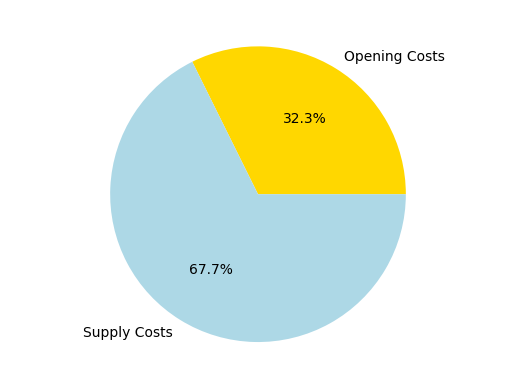

In [33]:
# 開設コストと供給コストの割合
if env.has_matplotlib:
    import matplotlib.pyplot as plt
    %matplotlib inline

def display_costs(costs, labels, colors):
    if env.has_matplotlib:
        plt.axis("equal")
        plt.pie(costs, labels=labels, colors=colors, autopct="%1.1f%%")
        plt.show()
    else:
        print("warning: no display")

display_costs(costs=[opening_cost_obj, supply_cost_obj],
              labels=["Opening Costs", "Supply Costs"],
              colors=["gold", "lightBlue"])

倉庫ごとの供給コストの内訳も表示できます。 まず、各倉庫の供給コスト値の合計を計算します。変数が true であるペア (w, s) について、w から s までの実際の供給コストを合計する必要があります (ここでは、値が >=0.9 であることをテストします)。 1 に等しい場合は、数値精度の問題により堅牢ではありません)

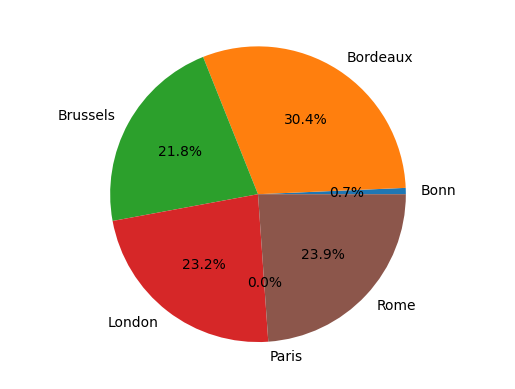

In [34]:
# 倉庫ごとの供給コストの割合
supply_cost_by_warehouse = [sum(supply_costs[w][s.id - 1]  
                                for s in stores if supply_vars[w,s].solution_value >= 0.9)
                             for w in warehouses]
wh_labels = [w.id for w in warehouses]
display_costs(supply_cost_by_warehouse, wh_labels, None)

# パレートフロンティアの探索
2 つのコストの合計を最小化することでモデルを解決し、開設コスト = 140、供給コスト = 293 で合計コスト 443 の最適解が得られたことを思い出してください。

場合によっては、これら 2 つのコストの絶対最小値はいくらなのか疑問に思うことも興味深いかもしれません。まず開設コストを最小限に抑え、次に供給コストを最小限に抑えたい場合はどうなるでしょうか (もちろん、前に得た最良の運営コストを維持します) 第1段階。

これは、モデルで「set_multi_objective」メソッド(旧solve_lexicographic)を使用する DOcplex で非常に簡単に実現できます。 このメソッドは 2 つの引数を取ります。最初の引数は式のリスト、2 番目の引数は感覚 (最小化または最大化) のリストで、デフォルトでは各式を最小化します。

このセクションでは、開店コストを最小化してから供給コストを最小化した場合と、逆に供給コストを最小化してから開店コストを最小化した場合に何が起こるかを検討します。

In [35]:
# 開設コストを優先して最小化する
warehouse_model.set_multi_objective(
    sense="min", exprs=[total_opening_cost, total_supply_cost], priorities=[1, 0])
ok = warehouse_model.solve()
opening1 = total_opening_cost.solution_value
supply1 = total_supply_cost.solution_value

print("total opening cost=%g" % opening1)
print("total supply cost=%g" % supply1)
print("toltal cost is %g" % (opening1 + supply1))

results.append((opening1, supply1))

total opening cost=120
total supply cost=352
toltal cost is 472


このことから、モデルは 2 回正常に解決され、オープニング コストの絶対最小値は 120 であり、この値に対して最小供給コストは 352 であることがわかります。最初の試行では、合計を最小化して (140,293) を取得しましたが、今では 120 が達成できる最良の値であることがわかりました。供給コストは 352 になり、合計コストは 472 になります。これは、合計を最適化したときに見つかった 433 という値よりも確かに大きいです。

次に、逆のことを行います。つまり、供給コストを最小化し、次にオープニング コストを最小化します。合計供給コストを最小化するという目標が、合計オープニング コストを最適化するという 2 番目の目標に取って代わったらどうなるでしょうか。コードは簡単です。

In [36]:
# 供給コストを優先して最小化する
warehouse_model.set_multi_objective(
    sense="min", exprs=[total_opening_cost, total_supply_cost], priorities=[0, 1])
ok = warehouse_model.solve()
opening2 = total_opening_cost.solution_value
supply2 = total_supply_cost.solution_value

print("total opening cost=%g" % opening2)
print("total supply cost=%g" % supply2)
print("toltal cost is %g" % (opening2 + supply2))

results.append((opening2, supply2))

total opening cost=152
total supply cost=288
toltal cost is 440


ここでは、(152, 288) が得られ、供給コストは 352 から 288 に下がりますが、開始コストは 120 から 152 に上がります。合計は 288+152 = 440 であることが確認できます。これは、最初に見つけた最適値 433 よりも大きいです。

# パレート図
合計の最適化結果、開始コスト優先、供給コスト優先の3 つの点を (開始コスト、供給コスト) 散布図にします。

[(140.0, 293.0), (120.0, 352.0), (152.0, 288.0)]


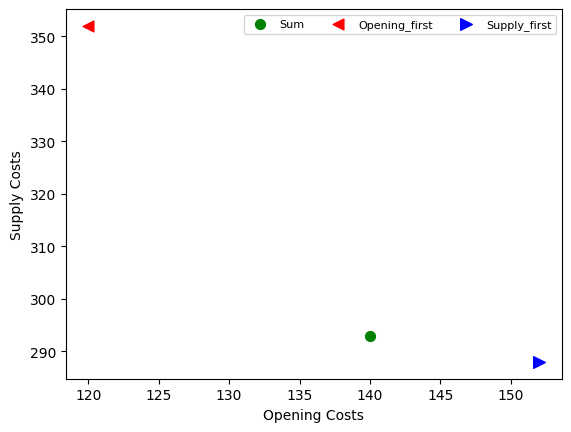

In [37]:
# パレート図
print (results)
def display_pareto(res):
    if env.has_matplotlib:
        plt.cla()
        plt.xlabel('Opening Costs')
        plt.ylabel('Supply Costs')
        colors = ['g', 'r', 'b']
        markers = ['o', '<', '>']
        nb_res = len(res)
        pts = []
        for i, r in enumerate(res):
            opening, supply = r
            p = plt.scatter(opening, supply, color=colors[i%3], s=50+10*i, marker=markers[i%3])
            pts.append(p)
        plt.legend(pts,
               ('Sum', 'Opening_first', 'Supply_first'),
               scatterpoints=1,
               loc='best',
               ncol=3,
               fontsize=8)
        plt.show()
    else:
        print("Warning: no display")

display_pareto(results)